In [1]:
from __future__ import absolute_import, division, print_function

# An Analysis of Citi Bike - 
## Revenue forecasting and customer growth potential


## Executive Summary


Using monthly revenue data from 2015 and 2016, I was able to build a model that captures the seasonality as well as the observed year-over-year growth. Using the learned model parameters, I can forecast the monthly performance. This forecast can be used as a key indicator to track business performance.

A demographic study of the annual subscribers in 2015 and 2016 reveals that female customers of age 35 years and up are a very promising customer segment for growth. This customer segment is underrepresented when compared to their younger peers, but showed increased growth from 2015 to 2016. Harnessing this growth momentum could yield an additional 4,300 annual customers, equaling a boost of revenue on the order of 700,000 USD.

## Introduction

Citi Bike (https://www.citibikenyc.com/) is a bike-sharing program in New York City. They operate several hundred stations across mostly Manhattan and Brooklyn. Customers can pick up bikes at a station and return them to any station after use.

The customer model currently distinguishes between annual customers (subscribers) and casual customers (1-day and 3-day passes). During the timeframe determined by the pass, the customer may take as many rides as desired. The duration of any single ride, however, is limited.

At the end of 2016, Citi Bike recorded:

* 120,000 active annual subscribers
* 14 million rides that year
* 40 million USD annual revenue

## Goals

The goal of this analytics project is to generate value for Citi Bike by providing trackable metrics and actionable insights.

A key metric for almost any business is current performance compared to expected performance. This allows decision makers to be constantly informed about the current state of the business and initiate action if required.

In a naturally seasonal business like Citi Bike (especially considering the location), forecasting expected performance is non-trivial. Simply comparing to previous months ignores the seasonality, while comparison with previous years may ignore growth trends or targets.

My first goal is therefore

* to provide a robust forecast of expected business performance.


A thorough understanding of the existing customers can yield important insights. It allows to tap into new growth opportunities without requiring (potentially risky) geographical expansion. My second goal in this report therefore is

* to identify customer segments with the most potential to grow.

## Data

The data used to drive these insights are publicly provided directly by Citi Bike ([System Data](https://www.citibikenyc.com/system-data)). They mainly consist of

* Monthly operating reports provided in PDF format
* A database of all rides taken (as .csv files)


The latter files can also be accessed via [Google Big Query](https://bigquery.cloud.google.com/table/bigquery-public-data:new_york.citibike_trips)

While the first set of data provides numbers on sales and revenue, the second set provides information on individual rides and on user demographics. Unfortunately, information does not cross over between both sources and the data as they are described above do not allow tracking of individual customers. This currently excludes any studies on customer churn or retention. However, the data set is still extremely powerful and allows me to expose highly relevant metrics for the business operation.

## Start of Analysis

## Imports

In [2]:
import datetime
import os

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from dateutil.relativedelta import relativedelta

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

%matplotlib inline


## Revenue data

In [3]:
# Set data directory relative to current working directory
data_dir = os.path.join(os.getcwd(),'..','..','data')
# Read revenue data (extracted from operational reports) to data frame
df_rev = pd.read_csv(os.path.join(data_dir,'citibike_financials.csv'))
df_rev.head()

,year,month,annual_membership,daily_membership,weekly_membership,3day_membership,casual_membership,annual_overages,casual_overages,other_revenue,refunds_and_discounts,taxes,sponsorship
0,2016,12,707292.0,0.0,0.0,0,166722.0,106021.0,71392.0,16551.0,96034.0,86513.0,350000.0
1,2016,11,855995.0,0.0,0.0,0,382525.0,182297.0,214826.0,37720.0,161486.0,134078.0,0.0
2,2016,10,1879996.0,0.0,0.0,0,618539.0,155886.0,282510.0,43197.0,206624.0,246238.0,2019743.0
3,2016,9,2849377.0,0.0,0.0,0,1114166.0,181111.0,428385.0,48236.0,180897.0,387445.0,0.0
4,2016,8,2952587.0,0.0,0.0,0,824894.0,157146.0,460426.0,45099.0,190321.0,370238.0,750000.0


In [4]:
# combine year and month and convert to datetime object
df_rev['date'] = df_rev['year'].apply(str) + '-' + df_rev['month'].apply(str)
df_rev['date'] = df_rev['date'].apply(pd.to_datetime)

In [5]:
# Calculate total revenue
df_rev['total_revenue'] = (df_rev['annual_membership'] + 
                           df_rev['casual_membership'] + 
                           df_rev['annual_overages'] + 
                           df_rev['casual_overages'] + 
                           df_rev['other_revenue'] - 
                           df_rev['refunds_and_discounts'] + 
                           df_rev['taxes'] + 
                           df_rev['sponsorship']) 

In [6]:
# Total revenue in 2016
total_revenue_2016 = df_rev['total_revenue'][df_rev['year'] == 2016].sum()

### Total revenue for 2016 (in USD):

In [7]:
print('{}'.format(total_revenue_2016))

43215767.0


In [8]:
# calculate total revenue for both customer cohorts
df_rev['total_subscriber_revenue'] = df_rev['annual_membership'] + df_rev['annual_overages']
df_rev['total_customer_revenue'] = df_rev['casual_membership'] + df_rev['casual_overages']

In [9]:
# Extract specific revenue information for 2015 and 2016
total_revenue_2016 = df_rev['total_revenue'][df_rev['year'] == 2016].sum()
sponsorship_revenue_2016 = df_rev['sponsorship'][df_rev['year'] == 2016].sum()
operational_revenue_2016 = total_revenue_2016 - sponsorship_revenue_2016
annual_revenue_2016 = df_rev['total_subscriber_revenue'][df_rev['year'] == 2016].sum()
casual_revenue_2016 = df_rev['total_customer_revenue'][df_rev['year'] == 2016].sum()
#
total_revenue_2015 = df_rev['total_revenue'][df_rev['year'] == 2015].sum()
sponsorship_revenue_2015 = df_rev['sponsorship'][df_rev['year'] == 2015].sum()
operational_revenue_2015 = total_revenue_2015 - sponsorship_revenue_2015
annual_revenue_2015 = df_rev['total_subscriber_revenue'][df_rev['year'] == 2015].sum()
casual_revenue_2015 = df_rev['total_customer_revenue'][df_rev['year'] == 2015].sum()

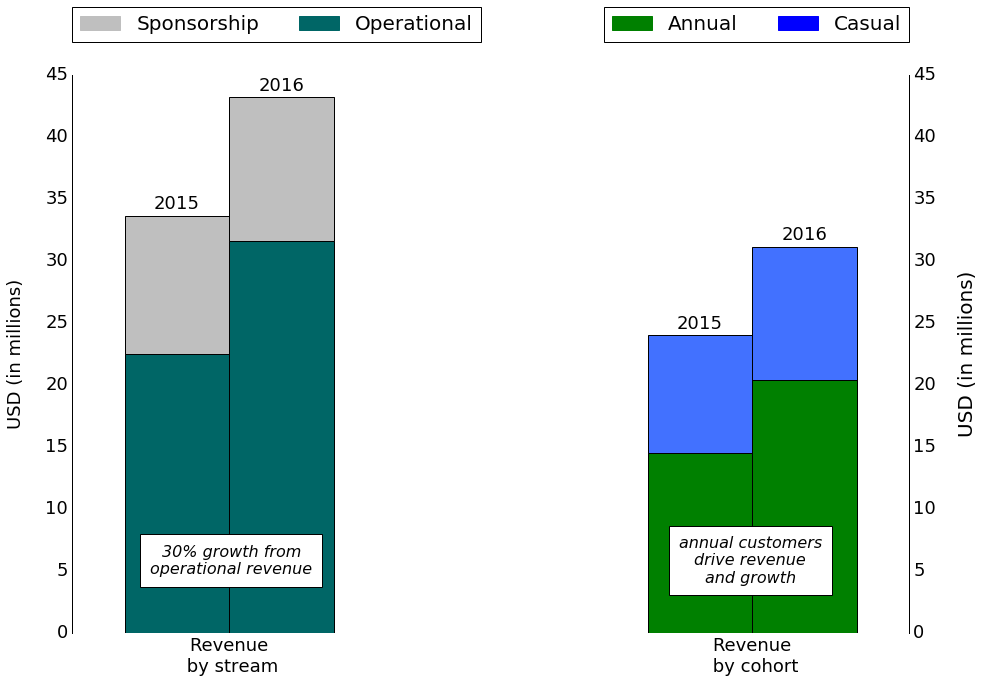

In [10]:
# Plot the revenue data
# Create the figure
fig, ax = plt.subplots(figsize=(15, 10))
# Set number of years/bars
N = 2
ind = np.arange(N)    # the x locations for the groups
width = 0.2       # the width of the bars: can also be len(x) sequence
#
# First set: 2015 data
#
# lower and upper part of the revenue bars
lower = (operational_revenue_2015/1e6,annual_revenue_2015/1e6)
upper = (sponsorship_revenue_2015/1e6,casual_revenue_2015/1e6)
# plot the bars
p1 = ax.bar(ind[0], lower[0], width, color='#006666',label='Operational')
p2 = ax.bar(ind[0], upper[0], width, color='0.75',
             bottom=lower[0],label='Sponsorship')
# label the bars
ax.text(ind[0]+width/2., 0.2+(lower[0]+upper[0]), '2015', ha='center', va='bottom', fontsize=18)
# plot the bars
p1 = ax.bar(ind[1], lower[1], width, color='green')
p2 = ax.bar(ind[1], upper[1], width, color=(0.2588,0.4433,1.0),
             bottom=lower[1])
# label the bars
ax.text(ind[1]+width/2., 0.2+(lower[1]+upper[1]), '2015', ha='center', va='bottom', fontsize=18)
#
#
# Second set: 2016 data
#
# lower and upper part of the revenue bars
lower = (operational_revenue_2016/1e6,annual_revenue_2016/1e6)
upper = (sponsorship_revenue_2016/1e6,casual_revenue_2016/1e6)
# plot the bars
p1 = ax.bar(ind[0]+width, lower[0], width, color='#006666',label='Operational')
p2 = ax.bar(ind[0]+width, upper[0], width, color='0.75',
             bottom=lower[0],label='Sponsorship')
# label the bars
ax.text(ind[0]+3*width/2., 0.2+(lower[0]+upper[0]), '2016', ha='center', va='bottom', fontsize=18)
# plot the bars
p1 = ax.bar(ind[1]+width, lower[1], width, color='green')
p2 = ax.bar(ind[1]+width, upper[1], width, color=(0.2588,0.4433,1.0),
             bottom=lower[1])
# label the bars
ax.text(ind[1]+3*width/2., 0.2+(lower[1]+upper[1]), '2016', ha='center', va='bottom', fontsize=18)
#
# label y axis
plt.ylabel('USD (in millions)', fontsize=18, labelpad=20)
# Manually add axis label for second y axis
ax.text(1.07, 0.5, 'USD (in millions)',
        horizontalalignment='center', 
        verticalalignment='center', 
        rotation=90,
        transform=ax.transAxes,fontsize=20)
# Acivate tick mark labels on second y axis
for tick in ax.yaxis.get_major_ticks():
    tick.label2On = True
# Adjust x-axis ticks and labels
ax.set_xticks(ind + width)
ax.set_xticklabels(('Revenue\n by stream','Revenue\n by cohort'))
ax.set_xlim(-width/2., ind[-1] + 2.5*width)
# No xaxis ticks but show text
ax.tick_params(axis=u'both', which=u'both',length=0,labelsize=18)
# Hide the top and bottom spines
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
# build legend patches
grey_patch = mpatches.Patch(color='0.75', label='Sponsorship')
greyblue_patch = mpatches.Patch(color='#006666', label='Operational')
green_patch = mpatches.Patch(color='green', label='Annual')
blue_patch = mpatches.Patch(color='blue', label='Casual')
# Show two legends
# http://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
legend1 = plt.legend(handles=[grey_patch,greyblue_patch],
                     bbox_to_anchor=(0., 1.06, 1., .102), 
                     loc=3, 
                     borderaxespad=0.,
                     prop={'size': 20},
                     ncol=2)
plt.legend(handles=[green_patch,blue_patch],
           bbox_to_anchor=(0., 1.02, 1., .102), 
           loc=1, 
           borderaxespad=0.,
           prop={'size': 20},
           ncol=2)
plt.gca().add_artist(legend1)
# add clarifying information on top of bars
ax.text(0.19, 0.13, '30% growth from\noperational revenue', style='italic',
        horizontalalignment='center', verticalalignment='center', 
        bbox={'facecolor':'white', 'alpha':1., 'pad':10},
        transform=ax.transAxes,fontsize=16)
ax.text(0.81, 0.13, 'annual customers\ndrive revenue\nand growth', style='italic',
        horizontalalignment='center', verticalalignment='center', 
        bbox={'facecolor':'white', 'alpha':1., 'pad':10},
        transform=ax.transAxes,fontsize=16)
# save the figure (pdf for presentation, png for markdown)
plt.savefig(os.path.join(data_dir,'plots','revenue_2015_2016.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(data_dir,'plots','revenue_2015_2016.png'), bbox_inches='tight')

For the sake of this analysis, the yearly revenue stream can be divided into operations revenue (sales of passes) and revenue from sponsorship fees.

The 30% growth in revenue between 2015 and 2016 is almost entirely carried by the operational revenue increase. And within the operational stream, annual customers drive a majority of the revenue and most of the growth.

In combination with the intrinsic value of annual members for a subscription-based business like Citi Bike, I will focus my analysis on annual customers only.


> <span style="color: red; font-size: 20pt;">Annual customers drive the majority of the operational revenue and most of the growth.</span>


## Monthly revenue trends

The monthly operating reports provide information on the number of annual passes that have been sold that month.

In [11]:
data_dir = os.path.join(os.getcwd(),'..','..','data')
df_sales = pd.read_csv(os.path.join(data_dir,'citibike_sales.csv'))
df_sales.head()

,year,month,yearly,weekly,three_day,daily,casual,active_annual_members
0,2013,6,26515,8044,0,67794,75838,52130
1,2013,7,14185,5980,0,49021,55001,66315
2,2013,8,10823,5244,0,51637,56881,77138
3,2013,9,8103,4634,0,52045,56679,85241
4,2013,10,7901,3386,0,34234,37620,93124


In [12]:
# combine year and month and convert to datetime object
df_sales['date'] = df_sales['year'].apply(str) + '-' + df_sales['month'].apply(str)
df_sales['date'] = df_sales['date'].apply(pd.to_datetime)

(735020.0, 736664.0)

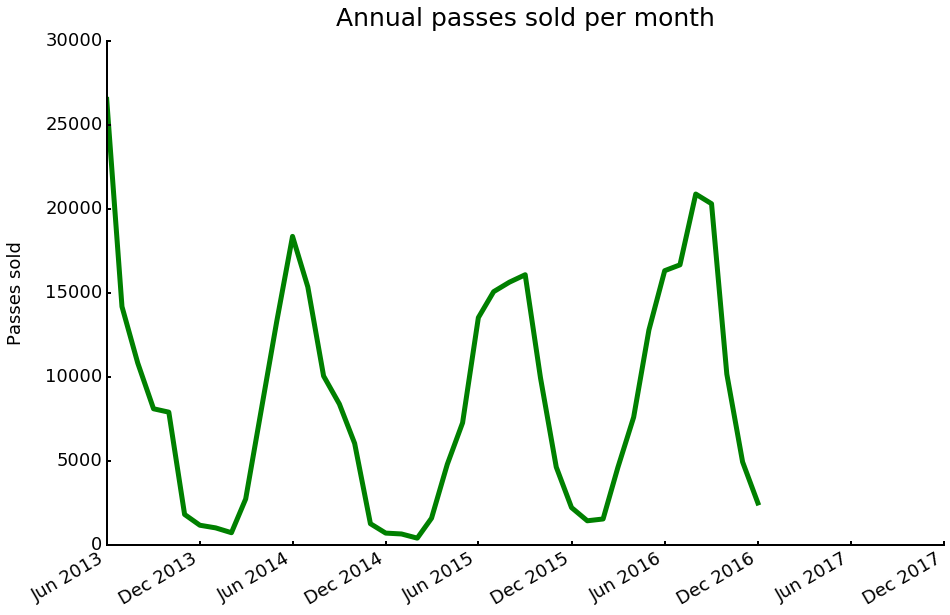

In [13]:
# Plot monthly sales of annual passes over time
# extract the relevant data
dates = df_sales['date'][(df_sales['active_annual_members'] > 0) & 
                         (df_sales['year'] >= 2013)].tolist()
yearly = df_sales['yearly'][(df_sales['active_annual_members'] > 0) & 
                            (df_sales['year'] >= 2013)].tolist()
# get figure object
fig, ax = plt.subplots(figsize=(15, 10))
# plot the data
plt.plot(dates,yearly,'g-', alpha=1,lw=5)
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis 
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# Adjust y-axis
plt.ylabel('Passes sold', fontsize=18)
ax.yaxis.labelpad = 20
plt.ylim(0,30000)
# Add title
plt.title('Annual passes sold per month', fontsize=25,y=1.02)
# St size of tick labels
ax.tick_params(labelsize=18)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# Expand x-axis out to +12 months
plt.xlim(dates[0],dates[-1]+ relativedelta(months=12))


### The strong seasonality is very obvious and makes a meaningful sales forecast non-trivial, in particular when combined with an additional growth expectation.


In [14]:
# Define gaussian functions for fitting
def double_gauss(x, a, b, x0, sigma, m, off):
    """
    Combination of two Gaussians. Same sigma, but different 
    peak height allowed. Added a linear slope underneath. 
    Peak offset fixed to 12 data points.
    """
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)) +
            a*b*np.exp(-(x-x0-12.)**2/(2*sigma**2)) +
            m*x+off)

def triple_gauss(x, a, b, x0, sigma, m, off):
    """
    Combination of three Gaussians. Peak height of third Gaussian 
    fixed to 2 times the (fitted) peak ratio between the first and 
    second. All Components have the same sigma. Added a linear slope 
    underneath. Peak distance between adjacent Gaussians fixed to 12 
    data points. 
    """
    return (a*np.exp(-(x-x0)**2/(2*sigma**2))+
            a*b*np.exp(-(x-x0-12.)**2/(2*sigma**2))+
            b*a*b*np.exp(-(x-x0-12.-12.)**2/(2*sigma**2))+
            m*x+off)


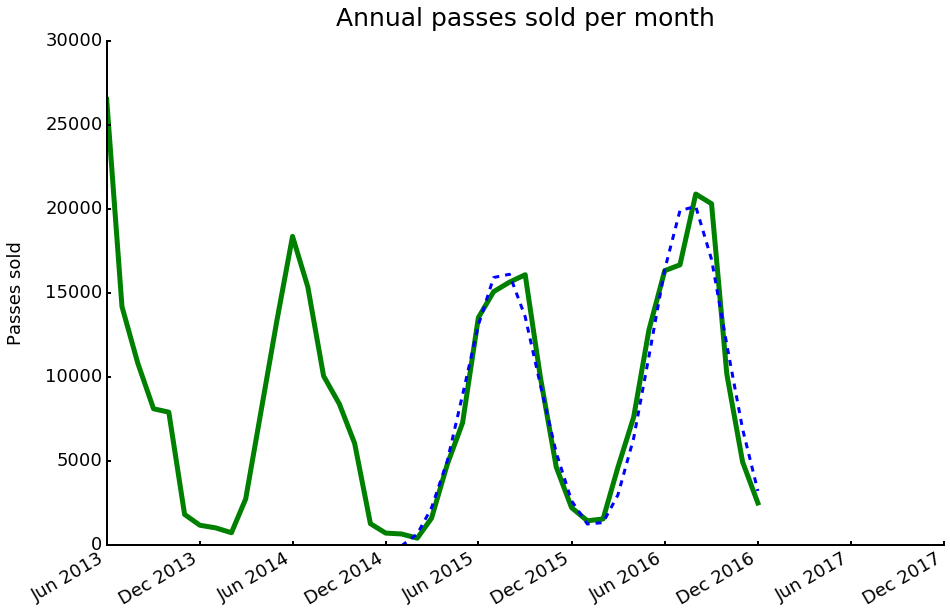

In [15]:
# Same figure as above, but add a fit for 2015 and 2016
# extract the relevant data
dates = df_sales['date'][(df_sales['active_annual_members'] > 0) & 
                         (df_sales['year'] >= 2013)].tolist()
yearly = df_sales['yearly'][(df_sales['active_annual_members'] > 0) & 
                            (df_sales['year'] >= 2013)].tolist()
# get figure object
fig, ax = plt.subplots(figsize=(15, 10))
# plot the data
plt.plot(dates,yearly,'g-', alpha=1,lw=5)
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis 
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# Adjust y-axis
plt.ylabel('Passes sold', fontsize=18)
ax.yaxis.labelpad = 20
plt.ylim(0,30000)
# Add title
plt.title('Annual passes sold per month', fontsize=25,y=1.02)
# St size of tick labels
ax.tick_params(labelsize=18)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# Expand x-axis out to +12 months
plt.xlim(dates[0],dates[-1]+ relativedelta(months=12))
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Fit data
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Limited fitting range
dates = df_sales['date'][(df_sales['active_annual_members'] > 0) & 
                         (df_sales['year'] >= 2015)].tolist()
yearly = df_sales['yearly'][(df_sales['active_annual_members'] > 0) & 
                            (df_sales['year'] >= 2015)].tolist()
# Generate input data for fitting function
num_points = len(yearly)
Tx = np.linspace(5., 8., num_points)
Tx = np.arange(num_points)
shp = df_sales['date'].shape
Tx = [np.abs(x-shp[0]) for x in Tx]
Tx = np.array(Tx[::-1])
tX = yearly
# Set boundaries and starting values
p0 = [1.7e4,1.3,27.,2.3,2.3,-400.]
param_bounds = ([1e4,1,25,0,0,-np.inf],
               np.inf)
# Perform the fit
popt, pcov = curve_fit(double_gauss, Tx, tX, p0=p0, bounds=param_bounds)
# save result for later
popt_dg = popt[:]
# Plot the fit 
plt.plot(dates,double_gauss(Tx, *popt),'b--',lw=3)



### Focusing on the years 2015 and 2016 only (the most stable years in terms of Citi Bike's business operations and leadership), the observed trends can be fit well with a model consisting of two linked Gaussian components.


### The model captures the seasonality and a growth trend well. Using the learned parameters I can create a forecast for the year 2017.


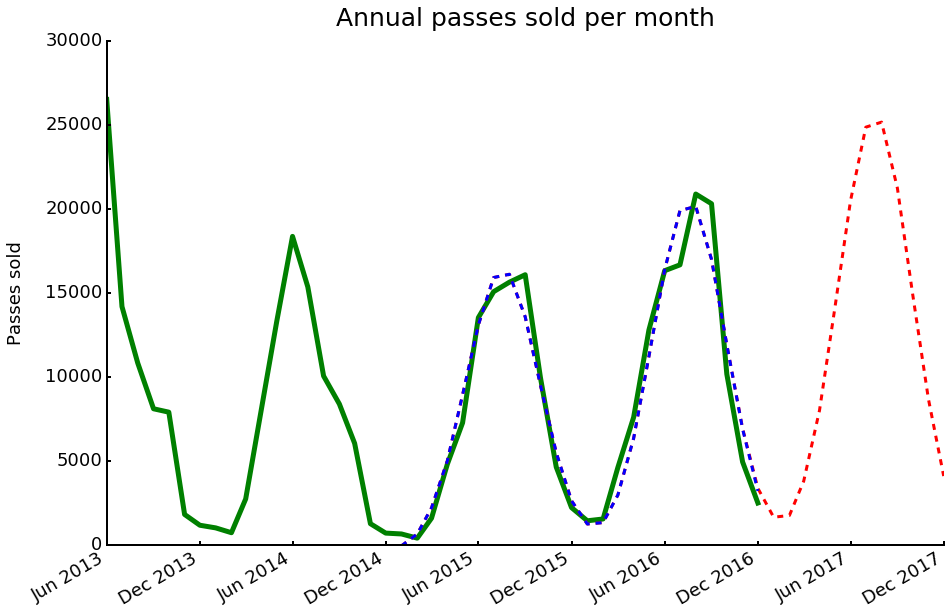

In [16]:
# SNow use fitted data to foreacast
# extract the relevant data
dates = df_sales['date'][(df_sales['active_annual_members'] > 0) & 
                         (df_sales['year'] >= 2013)].tolist()
yearly = df_sales['yearly'][(df_sales['active_annual_members'] > 0) & 
                            (df_sales['year'] >= 2013)].tolist()
# get figure object
fig, ax = plt.subplots(figsize=(15, 10))
# plot the data
plt.plot(dates,yearly,'g-', alpha=1,lw=5)
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# use a more precise date string for the x axis 
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# Adjust y-axis
plt.ylabel('Passes sold', fontsize=18)
ax.yaxis.labelpad = 20
plt.ylim(0,30000)
# Add title
plt.title('Annual passes sold per month', fontsize=25,y=1.02)
# St size of tick labels
ax.tick_params(labelsize=18)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# Expand x-axis out to +12 months
plt.xlim(dates[0],dates[-1]+ relativedelta(months=12))
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Fit data
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Limited fitting range
dates = df_sales['date'][(df_sales['active_annual_members'] > 0) & 
                         (df_sales['year'] >= 2015)].tolist()
yearly = df_sales['yearly'][(df_sales['active_annual_members'] > 0) & 
                            (df_sales['year'] >= 2015)].tolist()
# Generate input data for fitting function
num_points = len(yearly)
Tx = np.linspace(5., 8., num_points)
Tx = np.arange(num_points)
shp = df_sales['date'].shape
Tx = [np.abs(x-shp[0]) for x in Tx]
Tx = np.array(Tx[::-1])
tX = yearly
# Set boundaries and starting values
p0 = [1.7e4,1.3,27.,2.3,2.3,-400.]
param_bounds = ([1e4,1,25,0,0,-np.inf],
               np.inf)
# Perform the fit
popt, pcov = curve_fit(double_gauss, Tx, tX, p0=p0, bounds=param_bounds)
# save result for later
popt_dg = popt[:]
# Prepare new data for forecast
new_x = dates[:]
add_months = np.arange(12)
for i in add_months:
    new_x.append(new_x[-1] + relativedelta(months=1))
num_points = len(new_x)
new_Tx = np.arange(num_points)
new_Tx = [x+Tx[0] for x in new_Tx]
new_Tx = np.array(new_Tx)

# Plot initial fit and forecast
plt.plot(new_x,triple_gauss(new_Tx, *popt),'r--',lw=3)
plt.plot(dates,double_gauss(Tx, *popt),'b--',lw=3)





The forecast makes predictions about sales performance of annual passes under the assumption of static growth. This forecast metric can now be compared to actual monthly sales data. Significant deviations from the expected sales allow timely action to increase sales volume (e.g., marketing campaigns) or adjust growth expectations. The model can also take into account the newest data or business goals and update the forecast accordingly.

> <span style="color: red; font-size: 20pt; line-height: 150%;">Based on the newest operating report, sales of annual passes for January 2017 exceeded the forecast by 40%, indicating a favorable start into 2017.</span>

This sales result is unusual because it is the first time in the history of Citi Bike that the January sales numbers exceed the December sales. One obvious factor driving these additional sales is that January 2017 was unusually warm for NYC. It will therefore be insightful to see if this performance can be sustained in February.


## Number of rides vs. numer of customers

The rides data base provides demographic information only on a 'per ride' basis. Much of the following analysis will base directly on this data. The subsequent interpretation of the 'ground truth' results in terms of 'numbers of customers' is established in this section.

The task is clear: I have to establish the solid relation between 'number of rides taken' and 'number of active annual customers'.

On a monthly basis, the ratio of *number of rides taken by subscribers* (from the 'rides' data base) and the *number of active subscribers in the same month* (from the operating reports) show the expected seasonality.


In [17]:
# Get the data on the rides - these have been aggregated and extracted from the full data base of rides via SQL
df_rides = pd.read_csv(os.path.join(data_dir,'monthly_totals_subscriber.csv'))
# combine year and month and convert to datetime object
df_rides['date'] = df_rides['yr'].apply(str) + '-' + df_rides['mth'].apply(str)
df_rides['date'] = df_rides['date'].apply(pd.to_datetime)
df_rides.head()

,yr,mth,n_rides,date
0,2013,7,668501,2013-07-01
1,2013,8,815902,2013-08-01
2,2013,9,889190,2013-09-01
3,2013,10,940266,2013-10-01
4,2013,11,631801,2013-11-01


In [18]:
# Determine # of yearly passes sold per year
yearly_grouped = df_sales['yearly'].groupby(df_sales['year']).sum()
yearly_grouped

year
2013     70510
2014     77950
2015     91832
2016    119758
Name: yearly, dtype: int64

In [19]:
# Determine # of rides per year
n_rides_grouped = df_rides['n_rides'].groupby(df_rides['yr']).sum()
n_rides_grouped

yr
2013     4370245
2014     5752588
2015     8626638
2016    12301711
Name: n_rides, dtype: int64

In [20]:
# Rides per subscriber per year
print('{}\t{:>8s}\t{:>6s}\t{}'.format('Year','Rides','Sales','Rides per Sale'))
for idx in yearly_grouped.index.tolist():
    tmp_sales = yearly_grouped.loc[idx]
    tmp_rides = n_rides_grouped.loc[idx]
    tmp_ratio = tmp_rides/tmp_sales
    print('{}\t{:8.0f}\t{:6.0f}\t{:5.1f}'.format(idx,tmp_rides,tmp_sales,tmp_ratio))

Year	   Rides	 Sales	Rides per Sale
2013	 4370245	 70510	 62.0
2014	 5752588	 77950	 73.8
2015	 8626638	 91832	 93.9
2016	12301711	119758	102.7


In [21]:
# Determine 'rides_per_sale' ratio for each month in 2015 and 2016
years = [2015,2016]
months = np.arange(12)+1
dates = []
ratios = []
for year in years:
    for month in months:
        condition = (df_sales['year'] == year) & (df_sales['month'] == month)
        tmp_aam = df_sales['active_annual_members'][condition].values
        dates.append(df_sales['date'][condition].values)
        condition = (df_rides['yr'] == year) & (df_rides['mth'] == month)
        tmp_nrides = df_rides['n_rides'][condition].values
        tmp_ratio = tmp_nrides/tmp_aam
        ratios.append(tmp_ratio)

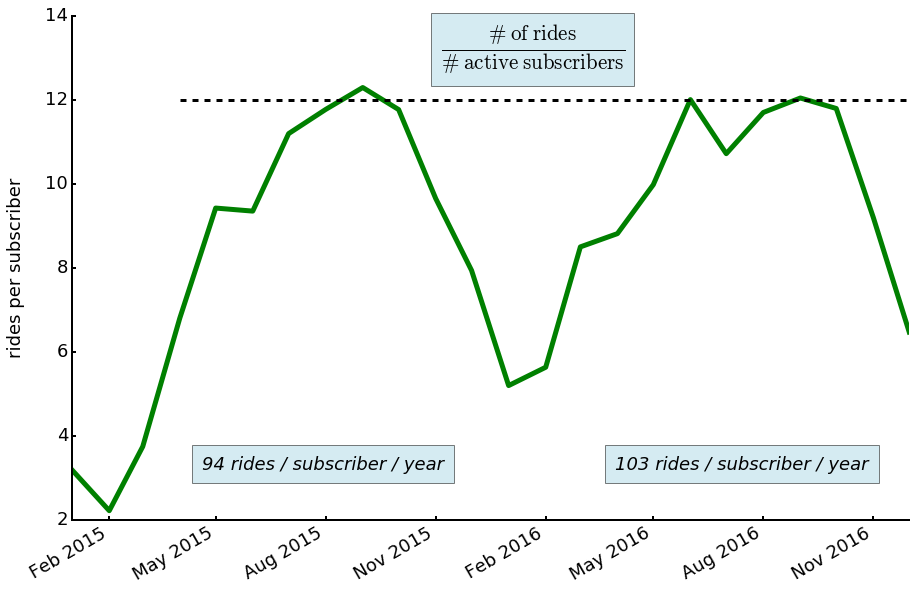

In [22]:
# Plot the results
# Create figure objects\
fig, ax = plt.subplots(figsize=(15, 10))
# plot data
plt.plot(dates,ratios,'g-', alpha=1,lw=5)
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
# adjsut y-axis
plt.ylabel('rides per subscriber', fontsize=18)
ax.yaxis.labelpad = 20
# set size of tick labels
ax.tick_params(labelsize=18)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# show horizontal line for guidance
plt.plot([dates[3],dates[-1]],[12,12],'k--',lw=3)
# give details on what is shown in plot
ax.text(0.55, 0.92, '$\\frac{\\rm{\#\; of\; rides}}{\#\; active\; subscribers}$', style='italic',
        horizontalalignment='center', bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':10},
        transform=ax.transAxes,fontsize=30)
# add aggregate for each year (see above for calculation)
ax.text(0.3, 0.1, '94 rides / subscriber / year', style='italic',
        horizontalalignment='center', bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':10},
        transform=ax.transAxes,fontsize=18)
ax.text(0.8, 0.1, '103 rides / subscriber / year', style='italic',
        horizontalalignment='center', bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':10},
        transform=ax.transAxes,fontsize=18)



More importantly, taking a yearly aggregate reveals that the number of rides taken by each customer remained - on average - constant within 10% between 2015 and 2016.

> <span style="color: red; font-size: 20pt; line-height: 150%;">The number of rides faithfully describes the number of customers.</span>


## User demographics

The Citi Bike data base provides demographic information (age, gender) for all rides taken by subscribers.


In [23]:
# Get the data on the rides. These have been aggregated as a histogram over age - separated by gender - and 
# extracted from the full data base of rides via SQL
df_2016 = pd.read_csv(os.path.join(data_dir,'subscriber_age_histogram_2016.csv'))
df_2016.head()

,age,c,num_males,num_females
0,16,6359,5021,1272
1,17,19359,15210,3952
2,18,30130,23932,5916
3,19,41402,32138,9246
4,20,74282,54214,19417


### Engagement histogram 2016

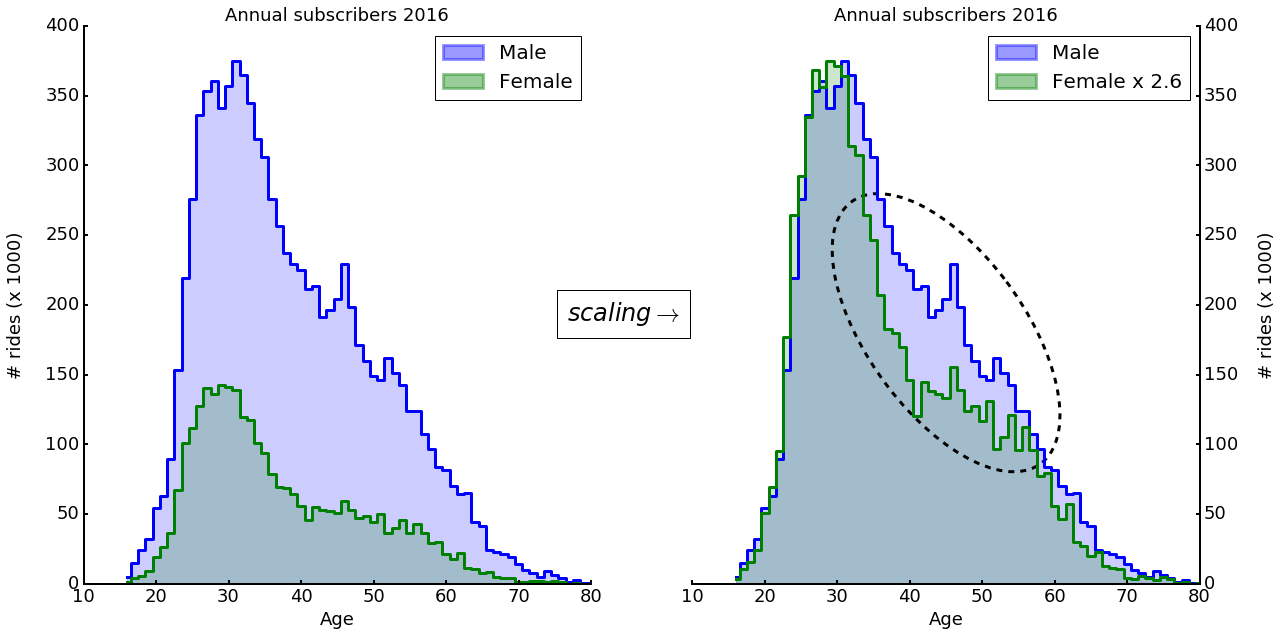

In [24]:
# Data
age = df_2016['age'][df_2016['age'] < 90]
male = df_2016['num_males'][df_2016['age'] < 90]
female = df_2016['num_females'][df_2016['age'] < 90]
# Create the figure object
fig, ax = plt.subplots(1,2,figsize=(20, 10))
# the width of the bars
width = 0.8
#
# #########
# left plot 
# #########
#
# Plot the histograms
ax[0].fill_between(age, 0, male/1e3, step='mid', color='b',label='Male', alpha=0.2)
rects1 = ax[0].step(age, male/1e3, where='mid', color='b',  lw=3)
ax[0].fill_between(age, 0, female/1e3, step='mid', color='g',label='Female', alpha=0.2)
rects1 = ax[0].step(age, female/1e3, where='mid', color='g',  lw=3)
# Labels
ax[0].set_title('Annual subscribers 2016', fontsize=18)
ax[0].set_xlabel('Age', fontsize=18)
ax[0].set_ylabel('# rides (x 1000)', fontsize=18, labelpad=20)
# Plot legend
green_patch = mpatches.Patch(label='Female', alpha=0.4, edgecolor='g', facecolor='g', lw=3)
blue_patch = mpatches.Patch(label='Male', alpha=0.4, edgecolor='b', facecolor='b', lw=3)
ax[0].legend(handles=[blue_patch,green_patch], prop={'size': 20})
# Hide the right and top spines
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax[0].spines['left'].set_linewidth(2)
ax[0].spines['bottom'].set_linewidth(2)
ax[0].xaxis.set_tick_params(width=2)
ax[0].yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax[0].yaxis.set_ticks_position('left')
ax[0].xaxis.set_ticks_position('bottom')
# Set size of tick labels
ax[0].tick_params(labelsize=18)
# Limit x-axis range
ax[0].set_xlim(10,80)
#
# #########
# right plot 
# #########
#
# Scaled data
scale_factor = max(male)/max(female)
# print('Scale factor: {}'.format(scale_factor))
female_scaled = female*scale_factor
# Plot the histograms
ax[1].fill_between(age, 0, male/1e3, step='mid', color='b',label='Male', alpha=0.2)
rects1 = ax[1].step(age, male/1e3, where='mid', color='b',  lw=3)
ax[1].fill_between(age, 0, female_scaled/1e3, step='mid', color='g',label='Female', alpha=0.2)
rects1 = ax[1].step(age, female_scaled/1e3, where='mid', color='g',  lw=3)
# Labels
ax[1].set_title('Annual subscribers 2016', fontsize=18)
ax[1].set_xlabel('Age', fontsize=18)
ax[1].set_ylabel('# rides (x 1000)', fontsize=18, labelpad=20)
# Move yaxis labels to the right
ax[1].yaxis.set_label_position("right")
# Plot legend
green_patch = mpatches.Patch(label='Female x 2.6', alpha=0.4, edgecolor='g', facecolor='g', lw=3)
blue_patch = mpatches.Patch(label='Male', alpha=0.4, edgecolor='b', facecolor='b', lw=3)
ax[1].legend(handles=[blue_patch,green_patch], prop={'size': 20})
# Hide the left and top spines
ax[1].spines['left'].set_visible(False)
ax[1].spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax[1].spines['right'].set_linewidth(2)
ax[1].spines['bottom'].set_linewidth(2)
ax[1].xaxis.set_tick_params(width=2)
ax[1].yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax[1].yaxis.set_ticks_position('right')
ax[1].xaxis.set_ticks_position('bottom')
# Set size of tick labels
ax[1].tick_params(labelsize=18)
# Limit x-axis range
ax[1].set_xlim(10,80)
# Add ellipse to highlight shoulder
ell = mpl.patches.Ellipse((0.5,0.45), width=0.6, height=0.3, angle = 130, transform=ax[1].transAxes,
                         facecolor='None', edgecolor='k', lw=3, ls='--')
ax[1].add_patch(ell)
# 
plt.figtext(0.5, 0.5, 'scaling$\\rightarrow$',fontsize=24,style='italic',
           bbox={'facecolor':'white', 'alpha':1., 'pad':10},
           horizontalalignment='center', verticalalignment='center',)

# plt.savefig(os.path.join(data_dir,'plots','subscriber_demographics_2016.pdf'), bbox_inches='tight')
# plt.savefig(os.path.join(data_dir,'plots','subscriber_demographics_2016.png'), bbox_inches='tight')


The age distribution for male and female subscribers is similar in shape, but male subscribers are responsible for 2.6 times (peak ratio) as many rides as female subscribers.

Scaling the distribution of the female subscribers to the same peak hight as the male subscribers reveals an obvious mismatch in the demographic rider profile. While younger women (20 to 35 years of age) show a similar engagement profile as men (modulo the overall scaling of 2.6), women at ages 35 to 55 are less engaged than their younger peers.

> <span style="color: red; font-size: 20pt; line-height: 150%;"> Drop in engagement for female subscribers of 35 to 55 years of age as compared to their younger peers.</span>

This immediately suggests a potential action:

---

<div style="color: blue; 
    font-size: 20pt; 
    padding: 20px; 
    border: 1px solid black; 
    margin: 0px 50px 0px 50px; 
    line-height: 150%; ">

**Action**<br>

Increase engagement for female subscribers with ages 35 and up. 

</div>

---



Support for this action comes from the growth Citi Bike has seen in the previous two years.

In [25]:
# Add 2015 age histogram data
df_2015 = pd.read_csv(os.path.join(data_dir,'subscriber_age_histogram_2015.csv'))
df_2015.head()

,age,c,num_males,num_females
0,17,4199,3430,769
1,18,13454,11133,2321
2,19,17430,13795,3628
3,20,31769,22943,8376
4,21,43858,34218,9640


(10, 80)

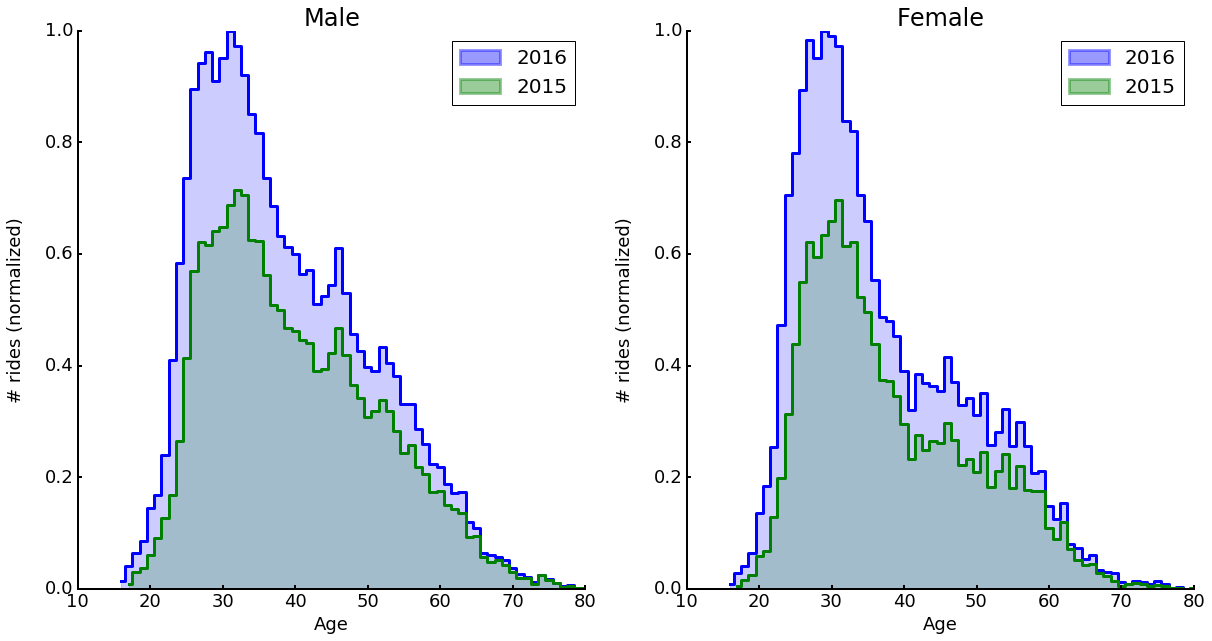

In [26]:
# Show the growth 2015 -> 2016 for male and female subscribers on the same scale
# Create figure object
fig, ax = plt.subplots(1,2,figsize=(20, 10))
# the width of the bars
width = 0.8
#
# #########
# Male data
# #########
#
age = (df_2015['age'][df_2015['age'] < 90],df_2016['age'][df_2016['age'] < 90])
male = (df_2015['num_males'][df_2015['age'] < 90],df_2016['num_males'][df_2016['age'] < 90])
# Plot normalized data
norm_factor = max(male[1])
ax[0].fill_between(age[1], 0, [x/norm_factor for x in male[1]], step='mid', color='b', alpha=0.2)
rects1 = ax[0].step(age[1], [x/norm_factor for x in male[1]], where='mid', color='b', label='2016', lw=3)
ax[0].fill_between(age[0], 0, [x/norm_factor for x in male[0]], step='mid', color='g', alpha=0.2)
rects1 = ax[0].step(age[0], [x/norm_factor for x in male[0]], where='mid', color='g', label='2015', lw=3)
# Labels
ax[0].set_title('Male', fontsize=24)
ax[0].set_xlabel('Age', fontsize=18)
ax[0].set_ylabel('# rides (normalized)', fontsize=18, labelpad=20)
# Plot legend
green_patch = mpatches.Patch(label='2015', alpha=0.4, edgecolor='g', facecolor='g', lw=3)
blue_patch = mpatches.Patch(label='2016', alpha=0.4, edgecolor='b', facecolor='b', lw=3)
ax[0].legend(handles=[blue_patch,green_patch], prop={'size': 20})
# Hide the right and top spines
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax[0].spines['left'].set_linewidth(2)
ax[0].spines['bottom'].set_linewidth(2)
ax[0].xaxis.set_tick_params(width=2)
ax[0].yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax[0].yaxis.set_ticks_position('left')
ax[0].xaxis.set_ticks_position('bottom')
# Set size of tick labels
ax[0].tick_params(labelsize=18)
# Limit x-axis raneg
ax[0].set_xlim(10,80)
#
# ###########
# Female data
# ###########
#
age = (df_2015['age'][df_2015['age'] < 90],df_2016['age'][df_2016['age'] < 90])
female = (df_2015['num_females'][df_2015['age'] < 90],df_2016['num_females'][df_2016['age'] < 90])
# the width of the bars
# Plot normalized data
norm_factor = max(female[1])
ax[1].fill_between(age[1], 0, [x/norm_factor for x in female[1]], step='mid', color='b',label='2016', alpha=0.2)
rects1 = ax[1].step(age[1], [x/norm_factor for x in female[1]], where='mid', color='b',  lw=3)
ax[1].fill_between(age[0], 0, [x/norm_factor for x in female[0]], step='mid', color='g',label='2015', alpha=0.2)
rects1 = ax[1].step(age[0], [x/norm_factor for x in female[0]], where='mid', color='g',  lw=3)
# Labels
ax[1].set_title('Female', fontsize=24)
ax[1].set_xlabel('Age', fontsize=18)
ax[1].set_ylabel('# rides (normalized)', fontsize=18, labelpad=20)
# Plot legend
green_patch = mpatches.Patch(label='2015', alpha=0.4, edgecolor='g', facecolor='g', lw=3)
blue_patch = mpatches.Patch(label='2016', alpha=0.4, edgecolor='b', facecolor='b', lw=3)
ax[1].legend(handles=[blue_patch,green_patch], prop={'size': 20})
# Hide the right and top spines
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax[1].spines['left'].set_linewidth(2)
ax[1].spines['bottom'].set_linewidth(2)
ax[1].xaxis.set_tick_params(width=2)
ax[1].yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax[1].yaxis.set_ticks_position('left')
ax[1].xaxis.set_ticks_position('bottom')
# Set size of tick labels
ax[1].tick_params(labelsize=18)
# Limit x-axis raneg
ax[1].set_xlim(10,80)
#
# plt.savefig(os.path.join(data_dir,'plots','subscriber_growth_demographics_2015_2016.pdf'), bbox_inches='tight')
# plt.savefig(os.path.join(data_dir,'plots','subscriber_growth_demographics_2015_2016.png'), bbox_inches='tight')





Engagement by male and female subscribers has grown from 2015 to 2016 across all ages. The growth ratio is very similar between between both user cohorts, except for the age bracket of 35 to 55 years. At these ages, engagement among women actually grew stronger over the last two years than for men.


In [27]:
# Growth ratios
condition = (df_2015['age'] > 20) & (df_2015['age'] < 70)
age_2015 = df_2015['age'][condition].tolist()
ratio_male = []
ratio_male_err = []
for tmp_age in age_2015:
    tmp_num_2015 = df_2015['num_males'][df_2015['age'] == tmp_age].iloc[0]
    tmp_num_2016 = df_2016['num_males'][df_2016['age'] == tmp_age].iloc[0]
    tmp_ratio = tmp_num_2016/tmp_num_2015
    ratio_male.append(tmp_ratio)
    # Assume Poisson error and propagate
    tmp_err_1 = np.sqrt(tmp_num_2015)
    tmp_err_2 = np.sqrt(tmp_num_2016)
    tmp_ratio_err = np.sqrt((tmp_err_1/tmp_num_2015)**2 + (tmp_err_2/tmp_num_2016)**2)
    ratio_male_err.append(tmp_ratio_err*tmp_ratio)
ratio_female = []
ratio_female_err = []
for tmp_age in age_2015:
    tmp_num_2015 = df_2015['num_females'][df_2015['age'] == tmp_age].iloc[0]
    tmp_num_2016 = df_2016['num_females'][df_2016['age'] == tmp_age].iloc[0]
    tmp_ratio = tmp_num_2016/tmp_num_2015
    ratio_female.append(tmp_ratio)
    # Assume Poisson error and propagate
    tmp_err_1 = np.sqrt(tmp_num_2015)
    tmp_err_2 = np.sqrt(tmp_num_2016)
    tmp_ratio_err = np.sqrt((tmp_err_1/tmp_num_2015)**2 + (tmp_err_2/tmp_num_2016)**2)
    ratio_female_err.append(tmp_ratio_err*tmp_ratio)
ratio_diff = [x-y for x,y in zip(ratio_female,ratio_male)]

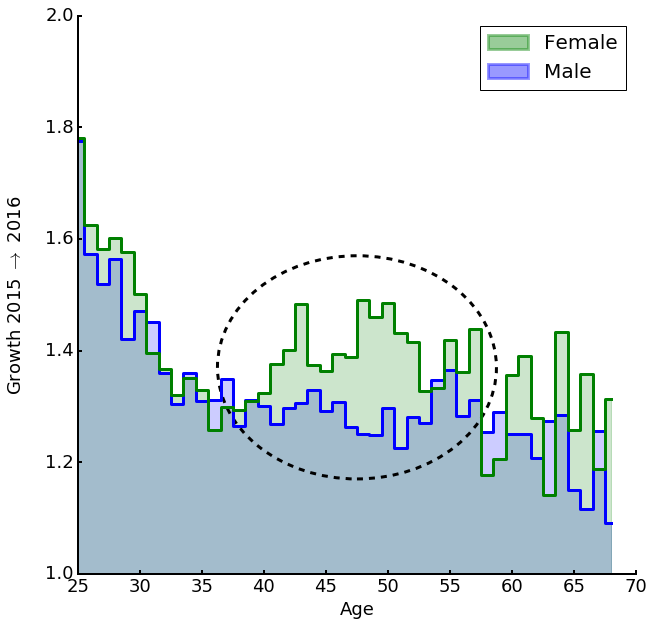

In [28]:
# Compare the growth ratios
# Create the figure object
fig, ax = plt.subplots(figsize=(10, 10))
# Data - limit the range to exclude very noisy data at the tail ends of the distributions
skip_begin = 4
skip_end = 1
tmp_x = age_2015[skip_begin:-skip_end]
tmp_y_male = ratio_male[skip_begin:-skip_end]
tmp_y_male_err = ratio_male_err[skip_begin:-skip_end]
tmp_y_female = ratio_female[skip_begin:-skip_end]
tmp_y_female_err = ratio_female_err[skip_begin:-skip_end]
# the width of the bars
width = 0.8       
# plot the data
ax.fill_between(tmp_x, 0, tmp_y_male, step='mid', color='b', alpha=0.2)
rects1 = ax.step(tmp_x, tmp_y_male, where='mid', color='b', lw=3)
ax.fill_between(tmp_x, 0, tmp_y_female, step='mid', color='g', alpha=0.2)
rects1 = ax.step(tmp_x, tmp_y_female, where='mid', color='g', lw=3)
# Labels
ax.set_xlabel('Age', fontsize=18)
ax.set_ylabel('Growth 2015 $\\rightarrow$ 2016', fontsize=18, labelpad=20)
# Show the legend
green_patch = mpatches.Patch(label='Female', alpha=0.4, edgecolor='g', facecolor='g', lw=3)
blue_patch = mpatches.Patch(label='Male', alpha=0.4, edgecolor='b', facecolor='b', lw=3)
ax.legend(handles=[green_patch,blue_patch], prop={'size': 20})
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Set witdh of axes spines and ticks
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# Set the size of the tick lables
ax.tick_params(labelsize=18)
# Limit the axis range
ax.set_ylim(1,2)
# Add ellipse to highlight growth
ell = mpl.patches.Ellipse((0.5,0.37), width=0.5, height=0.4, angle = 0, transform=ax.transAxes,
                         facecolor='None', edgecolor='k', lw=3, ls='--')
ax.add_patch(ell)


# plt.savefig(os.path.join(data_dir,'plots','subscriber_growth_ratio_2015_2016.pdf'), bbox_inches='tight')
# plt.savefig(os.path.join(data_dir,'plots','subscriber_growth_ratio_2015_2016.png'), bbox_inches='tight')




> <span style="color: red; font-size: 20pt; line-height: 150%;">Engagement among women 35 to 55 years of age grew stronger from 2015 to 2016 than for their male peers.</span>


---

<div style="color: blue; 
    font-size: 20pt; 
    padding: 20px; 
    border: 1px solid black; 
    margin: 0px 50px 0px 50px; 
    line-height: 150%;">

**Action**<br>

Harness the momentum seen for women at ages 35 to 55 and grow this cohort towards the level seen for their younger peers.

</div>

---


---

<div style="color: green; 
    font-size: 20pt; 
    padding: 20px; 
    border: 1px solid black; 
    margin: 0px 50px 0px 50px; 
    line-height: 150%;">


**Potential**<br>

Assuming that engagement among women at ages 35 to 55 can be increased to the same engagement profile as for their male peers (i.e., filling in the missing shoulder on the engagement histogram shown above), an additional 4,300 annual subscribers would be gained, translating into an increase in revenue on the order of $700,000 USD.

</div>

---

